In [1]:
import torch
import torchvision

from score_models.models.unet import UNet
from score_models.sampling import ddpm_sampling
from score_models.utils.noise import get_betas
from score_models.utils.visualisations import show_torch_images, tensors_to_gif

In [2]:
T=1_000
in_ch = 3
ch = 128
ch_mult = [1, 2, 3, 4]
attn = [2]
num_res_blocks = 2
dropout = 0.15
device = "cuda"
compile = True

# construct score model
score_model = UNet(
    T=T, 
    in_ch=in_ch, 
    ch=ch, 
    ch_mult=ch_mult, 
    attn=attn, 
    num_res_blocks=num_res_blocks, 
    dropout=dropout,
).to(device)

# compile model
if compile:
    score_model = torch.compile(score_model)

# load pre-trained model
path = "../scripts/checkpoints/ddpm_butterflies/260000.pt"
score_model.load_state_dict(
    torch.load(path)["model_state_dict"]
)

# define train step (i.e., criterion)
beta_min, beta_max = 1e-4, 2e-2
betas = get_betas(beta_min=beta_min, beta_max=beta_max, T=T)

In [3]:
history_buffer = []
x = torch.randn(4, 3, 128, 128).to(device)
samples = ddpm_sampling(
    x=x,
    score_model=score_model,
    alphas=betas["alphas"],
    alphas_bar=betas["alphas_bar"],
    sigmas=betas["sigmas"],
    history_buffer=history_buffer,
).cpu()

samples = torch.clamp(samples, -1, 1)

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


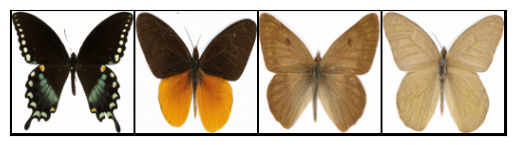

In [4]:
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
show_torch_images(grid)

In [5]:
# save to gif
subsampled_history_buffer = [history_buffer[i] for i in range(0, len(history_buffer), 10)]
tensors_to_gif(subsampled_history_buffer, "../imgs/ddpm-sampling.gif", duration=2.)